## 14-1. 프로젝트: 이제까지 만들었던 모델을 튜닝하고 배포하기!

이번 프로젝트는 여러분들이 배운 프로젝트중에서 CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포하는 미션입니다!

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 128 kB 5.7 MB/s            


# 1. Data Centric AI 맛보기

Data Centric AI를 공부했으니 한번 맛은 봐야겠죠? Data Centric AI를 정석적으로 진행한다면 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 합니다.
하지만 우리에게는 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하겠습니다.

## labelerrors.com

labelerrors.com은 Data Centric AI에서 가장 많이 활용하고 있는 파이썬 라이브러리인 cleanlab을 만든 개발자들이 공개한 사이트입니다. labelerrors.com은 이름에서 알 수 있듯이 테스트 데이터와 label이 잘못 붙어 있는 사례를 모아 보여줍니다.
labelerrors.com에서 CIFAR10 테스트 데이터셋을 확인하고 아래 조그맣게 있는 ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정해주세요.

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [3]:
# CIFAR10 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

170508288/170498071 [==============================] - 4s 0us/step


In [4]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [5]:
# 잘못된 레이블 수정
incorrect_label_id = 4794  # ID 4794의 레이블을 'bird'로 수정
correct_label = keras.utils.to_categorical([2], 10)  # CIFAR-10에서 'bird'의 레이블은 2입니다.
y_test[incorrect_label_id] = correct_label

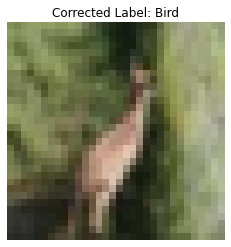

In [6]:
# 수정된 데이터 포인트 시각화
plt.imshow(x_test[incorrect_label_id])
plt.title(f"Corrected Label: Bird")
plt.axis('off')
plt.show()

In [7]:
# 고정된 모델 구조에 맞춘 모델 빌더 함수
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3), name='inputs'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Choice('dense_units', [256, 512, 1024]), activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)),
        tf.keras.layers.Dense(10, activation='softmax', name='outputs')
    ])
    
    # 'batch_size' 하이퍼파라미터를 튜닝 과정에서 설정
    batch_size = hp.Choice('batch_size', values=[32, 64, 128])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. 하이퍼파라미터 튜닝
위에 있는 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행합니다. 튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장해주세요.

## (주의사항)
하이퍼 파라미터를 어느정도 범위로 주는지에 따라서 모델 튜닝속도가 달라집니다.
학습시간을 고려해서 하이퍼 파라미터 튜닝을 세팅해주세요!

In [8]:
# Keras Tuner 설정
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory=os.path.join(os.getenv('HOME'), 'aiffel/mlops'),
    project_name='cifar10_keras_tuner'
)

Reloading Tuner from /aiffel/aiffel/mlops/cifar10_keras_tuner/tuner0.json


In [9]:
# 튜너 검색
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

In [10]:
# 최적의 하이퍼파라미터로 모델 재구축
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [11]:
# 모델훈련
model.fit(X_train, y_train, batch_size=best_hps.get('batch_size'), epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 45s 5ms/step - loss: 1.5033 - accuracy: 0.4820 - val_loss: 1.5218 - val_accuracy: 0.4758
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0639 - accuracy: 0.6274 - val_loss: 1.1703 - val_accuracy: 0.5968
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8549 - accuracy: 0.6994 - val_loss: 0.9781 - val_accuracy: 0.6624
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6818 - accuracy: 0.7612 - val_loss: 0.9867 - val_accuracy: 0.6698
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5275 - accuracy: 0.8166 - val_loss: 1.0893 - val_accuracy: 0.6599
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4093 - accuracy: 0.8573 - val_loss: 1.1883 - val_accuracy: 0.6604
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3220 - accuracy: 0.8881 - val_loss: 1.3636 - val_accuracy

In [12]:
# 모델 평가
eval_result = model.evaluate(x_test, y_test)
print(f"[Test Loss, Test Accuracy]: {eval_result}")

313/313 [==============================] - 1s 3ms/step - loss: 1.2989 - accuracy: 0.6873
[Test Loss, Test Accuracy]: [1.298948049545288, 0.6873000264167786]


In [13]:
# 모델 저장
save_path = os.path.join(os.getenv('HOME'), 'aiffel/mlops/cifar10_model')
fname = os.path.join(save_path, '1')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/cifar10_model/1/assets


# 3. 모델 배포하기 (옵션)
하이퍼파라미터 튜닝을 끝낸 모델을 Docker 혹은 WSL2 환경에서 TFServing을 진행해 모델을 배포하세요! 모델 배포가 성공했다면 해당 코드쉘을 캡쳐해서 이미지를 주피터 노트북에 넣어주세요!

- 해당부분은 클라우드 쉘에 보안상문제로 네트워크가 막혀있어 불가능함 만약하려면 로컬에서 진행해야하는데
  셋팅하는데도 시간이 오래걸려서 퍼실님도 나중에 프로젝트 할 때 할 기회가 있다고 하시면서 지금은 지나가라고 하심

## TFServing 우분투 터미널로 실습하기
우선 우분투 터미널 실습부터 진행하겠습니다!

클라우드 쉘을 열고 해당 스크립트를 넣어주세요!

$ echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

$ sudo apt update

$ sudo apt install tensorflow-model-server

해당 스크립트는 우분투에 tensorflow-model-server를 설치해 배포용 텐서플로우 서버를 구축하는 것입니다!

그 다음 스크립트는 모델을 배포하는 스크립트입니다.

$ tensorflow_model_server --port=8500 \
						 --rest_api_port=8501 \
						 --model_name=my_model \
						 --model_base_path=/aiffel/mlops/best_model/model 
여기서 model_base_path는 실제 SavedModel을 넣은 디렉토리로 바꿔주세요! (주의사항) SavedModel을 넣을 때 model 디렉토리 내부에 숫자 '1' 폴더를 만들고 넣어주세요!

## TFServing Docker로 실습하기
Docker를 설치하셨다면

docker pull tensorflow/serving
을 WSL2 쉘에 실행시켜주세요 (맥북은 터미널에서도 가능합니다!)

docker run -p 8500:8500 \
			-p 8501:8501 \
			--mount type=bind, source=/tmp/models, target=/models/my_model
			-e MODEL_NAME=my_model \
			-e MODEL_BASE_PATH=/models/my_model \
			-t tensorflow/serving
그 다음 도커를 지정해주고 실행시켜 주세요

해당 명령어의 경우 첫번째 줄은 기본 포트를 지정하는 것이며 2번째줄은 API 포트를 의미합니다. 3번째 줄은 모델 티렉토리를 마운트하는 것입니다. 4번째 줄은 모델 이름을 지정해주고 5번째 줄은 모델의 기본 경로를 의미합니다. 마지막 줄은 tensorflow/serving을 사용한다는 뜻입니다!

In [14]:
load_path = os.getenv('HOME') + '/aiffel/mlops/cifar10_model/1'
best_model = tf.keras.models.load_model(load_path)

In [15]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

# 4. TFLite 모델 만들기 (옵션)
여러분들이 만든 모델을 TFLite 모델로 만들어서 저장하고 서명을 확인하는 메소드까지 입력해주세요!

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpn_qkic66/assets


In [17]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()

In [18]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

ValueError: Invalid signature_def_name provided.

### - 쥬피터 노트북에서는 서명이 안되는 문제가 있음

# 회고

- 이번에는 LMS에서 진행하는데 한계가 있어 모든 실습을 하지못해 아쉬웠다
- 시간이 없어서 프로젝트 목표달성 정확도 개선을 위한 하이퍼 파라미터 튜닝을
  많이 하지못해 아쉬웠다
- abelerrors.com을 통해 테스트 데이터셋의 잘못된 라벨을 확인하고, 이를 수정하는 것이 재미있었다
- 이 프로젝트를 통해 딥 러닝 모델 개발 및 배포의 기본 원리를 배웠습니다. 앞으로는 실제 응용 분야에서 더 많은 경험을 쌓고, 다양한 프로젝트에 참여하여 실력을 향상시킬 계획입니다.